# Functional Annotation Analysis

In [1]:
import copy
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output',
                      'functional_annotation_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'functional_annotation_analysis')
cpy.makedir(private_outdir)

In [2]:
parallel_client = Client(profile='parallel')
dview = parallel_client[:]
print('Cluster has {} engines.'.format(len(parallel_client.ids)))

Cluster has 250 engines.


In [3]:
with dview.sync_imports():
    import cdpybio
    import pybedtools
    import scipy
    import scipy.stats
    import subprocess

importing cdpybio on engine(s)
importing pybedtools on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)
importing subprocess on engine(s)


In [4]:
%px cpb = cdpybio
%px pbt = pybedtools

In [46]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants_single.tsv')
lead_vars_single = pd.read_table(fn, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [57]:
sig = lead_vars[(lead_vars.perm_sig) & (lead_vars.variant_type != 'cnv')]
sig = sig.sort_values(by='pvalue')
sig = sig.drop_duplicates(subset='gene_id')

In [60]:
n = len(set(sig.location))
print('{:,} distinct lead SNVs.'.format(n))

5,420 distinct lead SNVs.


In [61]:
exons = pbt.BedTool(cpy.gencode_exon_bed)
exons = exons.sort().merge()

In [62]:
# Make bed file for most sig SNVs.
s = set(sig.chrom + '\t' + sig.start.astype(int).astype(str) + 
        '\t' + sig.end.astype(int).astype(str))
snvs = pbt.BedTool('\n'.join(s) + '\n', from_string=True)
snvs = snvs.sort()

# Get intergenic SNVs.
intergenic_snvs = snvs.intersect(exons, v=True)

# 5kb window centered on SNVs.
intergenic_window = intergenic_snvs.slop(l=2500, r=2500, g=pbt.genome_registry.hg19)

dview.push(dict(intergenic_snvs=intergenic_snvs,
                intergenic_window=intergenic_window));

In [63]:
n = len(intergenic_snvs)
print('{:,} intergenic lead SNVs.'.format(n))

4,491 intergenic lead SNVs.


In [65]:
def calc_bed_enrichment_from_url(url, variants, variants_window):
    """Calculate enrichment for bed file from a URL for variants
    vs. variants_window"""
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True)
    bt = bt.sort()
    bt = bt.merge()
    res = variants.intersect(bt, sorted=True, wo=True)
    eqtl_in_peak = len(res)
    eqtl_out_peak = len(variants) - eqtl_in_peak

    res = variants_window.intersect(bt, sorted=True, wo=True)
    not_eqtl_in_peak = 0
    for r in res:
        not_eqtl_in_peak += int(r.fields[-1])
    not_eqtl_in_peak -= eqtl_in_peak
    
    total = 0
    for r in variants_window:
        total += r.length
    not_eqtl_out_peak = total - not_eqtl_in_peak - eqtl_in_peak - eqtl_out_peak
    
    oddsratio, p = scipy.stats.fisher_exact([[eqtl_in_peak, eqtl_out_peak],
                                             [not_eqtl_in_peak, not_eqtl_out_peak]])
    return url, oddsratio, p

In [66]:
dview.push(dict(calc_bed_enrichment_from_url=calc_bed_enrichment_from_url));

In [67]:
def calc_bed_enrichment(bt):
    """Calculate enrichment for a pybedtools object"""
    res = intergenic_snvs.intersect(bt, sorted=True, wo=True)
    eqtl_in_peak = len(res)
    eqtl_out_peak = len(intergenic_snvs) - eqtl_in_peak

    res = intergenic_window.intersect(bt, sorted=True, wo=True)
    not_eqtl_in_peak = 0
    for r in res:
        not_eqtl_in_peak += int(r.fields[-1])
    not_eqtl_in_peak -= eqtl_in_peak
    
    total = 0
    for r in intergenic_window:
        total += r.length
    not_eqtl_out_peak = total - not_eqtl_in_peak - eqtl_in_peak - eqtl_out_peak
    
    oddsratio, p = fisher_exact([[eqtl_in_peak, eqtl_out_peak],
                                 [not_eqtl_in_peak, not_eqtl_out_peak]])
    return oddsratio, p

## Roadmap ChIP-Seq and DNase

I'm going to compare the eQTL variants to the Roadmap iPSC data.

In [68]:
a = os.path.join(outdir, 'roadmap_ipsc_peak_pvalues.tsv')
b = os.path.join(outdir, 'roadmap_ipsc_peak_oddsratios.tsv')
if sum([os.path.exists(x) for x in [a, b]]) != 2:
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(.*\.gz)"', html)
    lines = [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
    files = [x for x in files if x.split('-')[0] in lines]
    files = [x for x in files if 'hotspot' not in x]

    roadmap_peak_pvals = pd.DataFrame(
        -1, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))
    roadmap_peak_oddsratios = pd.DataFrame(
        0, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    res = dview.map_sync(lambda x: calc_bed_enrichment_from_url(x, intergenic_snvs, intergenic_window),
                         urls)

    for r in res:
        n = os.path.split(r[0])[1]
        roadmap_peak_pvals.ix[n.split('-')[0], n.split('-')[1].split('.')[0]] = r[2]
        roadmap_peak_oddsratios.ix[n.split('-')[0], n.split('-')[1].split('.')[0]] = r[1]
    roadmap_peak_pvals.index = roadmap_ids[roadmap_peak_pvals.index]
    roadmap_peak_oddsratios.index = roadmap_ids[roadmap_peak_oddsratios.index]
    roadmap_peak_pvals.to_csv(a, sep='\t')
    roadmap_peak_oddsratios.to_csv(b, sep='\t')
else:
    roadmap_peak_pvals = pd.read_table(a, index_col=0)
    roadmap_peak_oddsratios = pd.read_table(b, index_col=0)

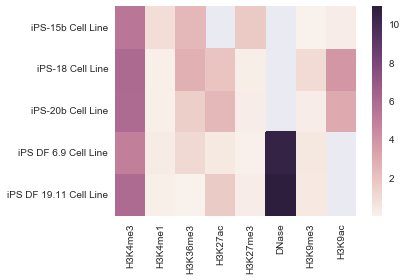

In [69]:
sns.heatmap(-np.log10(roadmap_peak_pvals))
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'roadmap_chip_seq_pval_heatmap.pdf'))

Given the enrichment in DNase peaks, I want to look at the enrichment for
other cell types' DNase peaks.

In [70]:
fn = os.path.join(outdir, 'roadmap_dnase_res.tsv')
if not os.path.exists(fn):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    res = dview.map_sync(lambda x: calc_bed_enrichment_from_url(x, intergenic_snvs, intergenic_window),
                         urls)
    
    for r in res:
        n = os.path.split(r[0])[1]
        roadmap_dnase_res.ix[n.split('-')[0], 'odds_ratio'] = r[1]
        roadmap_dnase_res.ix[n.split('-')[0], 'pvalue'] = r[2]
    roadmap_dnase_res.to_csv(fn, sep='\t')
else:
    roadmap_dnase_res = pd.read_table(fn, index_col=0)
roadmap_dnase_res.index = roadmap_ids[roadmap_dnase_res.index]

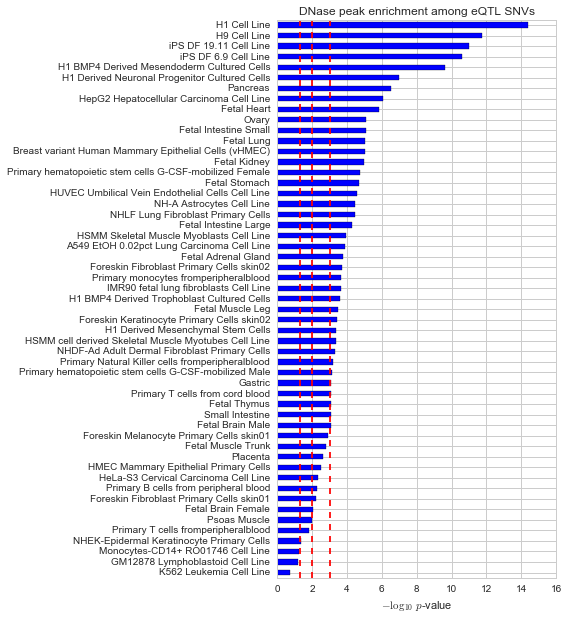

In [71]:
with sns.axes_style('whitegrid'):
    t = roadmap_dnase_res.sort_values(by='pvalue', ascending=False)
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    #(-np.log10(t.pvalue.tail(30))).plot(kind='barh')
    (-np.log10(t.pvalue)).plot(kind='barh', ax=ax)
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_ylabel('')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='red', linestyle='--')
    ax.set_title('DNase peak enrichment among eQTL SNVs')
    #fig.tight_layout();

## ENCODE DNase and H1-hESC Transcription Factor Binding

I want to get all of the ENCODE DNase data. I need to keep track of

* the experiment accession (everything can be reconstructed from this)
* cell type
* organ
* life stage
* biosample treatment
* the narrowPeak accession
* the narrowPeak URL

The cell below takes a little while to run but only needs to run once because
we'll save the results.

In [72]:
# Get DNase experiments.
fn = os.path.join(outdir, 'encode_dnase.tsv')
if not os.path.exists(fn):
    s = ('?type=experiment&assay_term_name=DNase-seq&assembly=hg19&'
         'files.file_type=bigBed%20narrowPeak')
    dnase_exp = pet.search(s, limit=1000)

    bad = []
    exp_acc = []
    cell_type = []
    peak_acc = []
    peak_url = []
    biosample_type = []
    for r in dnase_exp:
        r.fetch()
        keep = []
        for f in r.files:
            f.fetch()
            if f.file_type == 'bed narrowPeak':
                keep.append(f)
        if len(keep) > 0:
            cur_f = keep.pop()
            # It seems that some date_created attributes aren't formatted correctly.
            # I'll just end up taking a random bed file for these or the one that 
            # has the date formatted correctly.
            try:
                year, month, day = [int(x) for x in cur_f.date_created.split('-')]
                cur_date = dt.date(year, month, day)
            except ValueError:
                cur_date = dt.date(1900, 1, 1)
                bad.append(r.accession)
            while len(keep) > 0:
                new_f = keep.pop()
                try:
                    year, month, day = [int(x) for x in new_f.date_created.split('-')]
                    new_date = dt.date(year, month, day)
                except ValueError:
                    new_date = dt.date(1900, 1, 1)
                    bad.append(r.accession)
                if new_date > cur_date:
                    cur_f = new_f
                    cur_date = new_date
            exp_acc.append(r.accession)
            cell_type.append(r.biosample_term_name)
            biosample_type.append(r.biosample_type)
            peak_acc.append(cur_f.accession)
            peak_url.append('https://www.encodeproject.org{}'.format(cur_f.href))

    encode_dnase = pd.DataFrame({'cell_type': cell_type, 
                                 'narrowPeak_accession':peak_acc, 
                                 'narrowPeak_url': peak_url,
                                 'biosample_type': biosample_type},
                                index=exp_acc)
    encode_dnase.to_csv(fn, sep='\t')
else:
    encode_dnase = pd.read_table(fn, index_col=0)

In [73]:
fn = os.path.join(outdir, 'encode_dnase_res.tsv')
if not os.path.exists(fn):
    encode_dnase_res = pd.DataFrame(
        -1, index=encode_dnase.index, 
        columns=['odds_ratio', 'pvalue'])
    
    urls = list(encode_dnase.narrowPeak_url)
    res = dview.map_sync(lambda x: calc_bed_enrichment_from_url(x, intergenic_snvs, intergenic_window),
                         urls)
    
    for r in res:
        e = encode_dnase[encode_dnase.narrowPeak_url == r[0]].index[0]
        encode_dnase_res.ix[e, 'odds_ratio'] = r[1]
        encode_dnase_res.ix[e, 'pvalue'] = r[2]
    encode_dnase_res = encode_dnase_res.join(encode_dnase)
    encode_dnase_res.to_csv(fn, sep='\t')
else:
    encode_dnase_res = pd.read_table(fn, index_col=0)

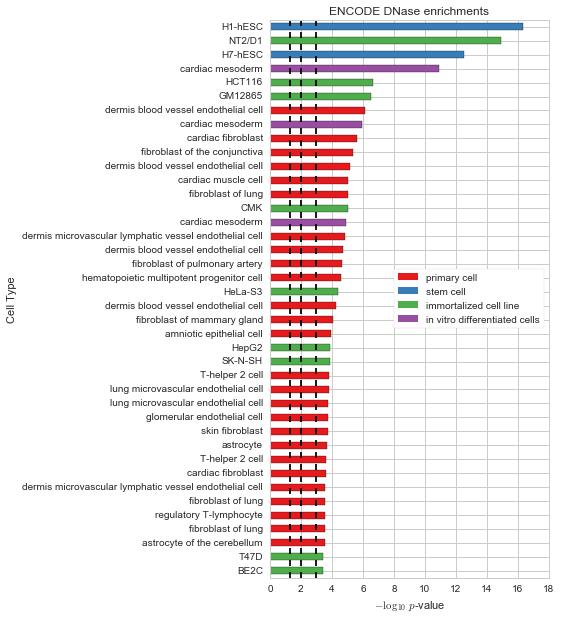

In [120]:
with sns.axes_style('whitegrid'):
    #t = encode_dnase[encode_dnase.biosample_type != 'immortalized cell line']
    t = encode_dnase[encode_dnase.lab == 'john-stamatoyannopoulos']
    t = encode_dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(40)
    cdict = dict(zip(set(encode_dnase.ix[t.index, 'biosample_type']), sns.color_palette('Set1')))
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    c = [cdict[x] for x in encode_dnase.ix[t.index, 'biosample_type']]
    ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
    ax.set_ylabel('Cell Type')
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_title('ENCODE DNase enrichments')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='black', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='black', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='black', linestyle='--')
    ax.set_yticklabels(encode_dnase.ix[t.index, 'cell_type'])
    rects = []
    labels = []
    for k in cdict.keys():
        labels.append(k)
        r = Rectangle((0, 0), 0, 0, fc=cdict[k])
        rects.append(r)
    lgd = ax.legend(rects, labels, loc='center right',
                    frameon=True)#, prop={'size':8})
    for p in lgd.get_patches():
        p.set_linewidth(0)

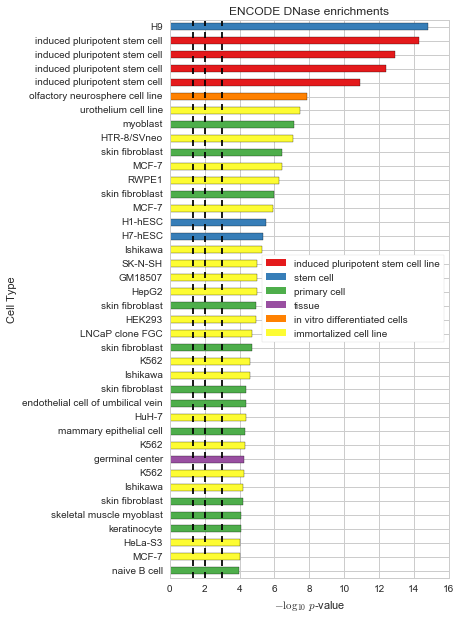

In [119]:
with sns.axes_style('whitegrid'):
    #t = encode_dnase[encode_dnase.biosample_type != 'immortalized cell line']
    t = encode_dnase[encode_dnase.lab == 'gregory-crawford']
    t = encode_dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(40)
    cdict = dict(zip(set(encode_dnase.ix[t.index, 'biosample_type']), sns.color_palette('Set1')))
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    c = [cdict[x] for x in encode_dnase.ix[t.index, 'biosample_type']]
    ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
    ax.set_ylabel('Cell Type')
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_title('ENCODE DNase enrichments')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='black', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='black', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='black', linestyle='--')
    ax.set_yticklabels(encode_dnase.ix[t.index, 'cell_type'])
    rects = []
    labels = []
    for k in cdict.keys():
        labels.append(k)
        r = Rectangle((0, 0), 0, 0, fc=cdict[k])
        rects.append(r)
    lgd = ax.legend(rects, labels, loc='center right',
                    frameon=True)#, prop={'size':8})
    for p in lgd.get_patches():
        p.set_linewidth(0)

I'd like to progammatically obtain all of the relevant ChIP-seq
datasets. I need to go into ChIP-seq experiment and find the 
narrowPeak files. I'll take one of the narrowPeaks that was most
recently released. Often there are two replicates but I think 
using one will be fine for now. If I want to use both, I probably
need to assume that both replicates were released on the same date
because it seems like it's hard to figure out which replicate a 
narrowPeak file is from.

I need to record 

* the experiment accession (everything can be reconstructed from this)
* the cell type
* the target
* the narrowPeak accession
* the narrowPeak URL

In [76]:
# Get ChIP-seq experiments.
fn = os.path.join(outdir, 'encode_stem_cell_chip_seq.tsv')
if not os.path.exists(fn):
    s = ('?type=experiment&assay_term_name=ChIP-seq&'
         'replicates.library.biosample.donor.organism.scientific_name=Homo%20sapiens&'
         'replicates.library.biosample.biosample_type=stem%20cell&files.file_type=bed%20narrowPeak')
    chip_seq_exp = pet.search(s, limit=1000)

    exp_acc = []
    cell_type = []
    target = []
    target_type = []
    peak_acc = []
    peak_url = []
    for r in chip_seq_exp:
        r.fetch()
        keep = []
        for f in r.files:
            f.fetch()
            if f.file_type == 'bed narrowPeak':
                keep.append(f)
        if len(keep) > 0:
            cur_f = keep.pop()
            year, month, day = [int(x) for x in cur_f.date_created.split('-')]
            cur_date = dt.date(year, month, day)
            while len(keep) > 0:
                new_f = keep.pop()
                year, month, day = [int(x) for x in new_f.date_created.split('-')]
                new_date = dt.date(year, month, day)
                if new_date > cur_date:
                    cur_f = new_f
                    cur_date = new_date
            exp_acc.append(r.accession)
            cell_type.append(r.biosample_term_name)
            t = r.target
            t.fetch()
            target.append(t.label)
            target_type.append(', '.join(sorted(t.investigated_as)))
            peak_acc.append(cur_f.accession)
            peak_url.append('https://www.encodeproject.org{}'.format(cur_f.href))

    encode_chip_seq = pd.DataFrame({'cell_type': cell_type, 
                                    'target': target,
                                    'target_type': target_type,
                                    'narrowPeak_accession':peak_acc, 
                                    'narrowPeak_url': peak_url},
                                   index=exp_acc)
    encode_chip_seq.to_csv(fn, sep='\t')
else:
    encode_chip_seq = pd.read_table(fn, index_col=0)

In [77]:
fn = os.path.join(outdir, 'encode_stem_cell_chip_seq_res.tsv')
if not os.path.exists(fn):
    encode_chip_seq_res = pd.DataFrame(
        -1, index=encode_chip_seq.index, 
        columns=['odds_ratio', 'pvalue'])
    
    urls = list(encode_chip_seq.narrowPeak_url)
    res = dview.map_sync(lambda x: calc_bed_enrichment_from_url(x, intergenic_snvs, intergenic_window),
                         urls)
    for r in res:
        i = encode_chip_seq[encode_chip_seq.narrowPeak_url == r[0]].index[0]
        encode_chip_seq_res.ix[i, 'odds_ratio'] = r[1]
        encode_chip_seq_res.ix[i, 'pvalue'] = r[2]
    encode_chip_seq_res = encode_chip_seq_res.join(encode_chip_seq)
    num_peaks = []
    for url in encode_chip_seq_res.narrowPeak_url.values:
        s = cpb.general.read_gzipped_text_url(url)
        num_peaks.append(len(s.strip().split('\n')))
    encode_chip_seq_res['num_peaks'] = num_peaks
    encode_chip_seq_res.to_csv(fn, sep='\t')
else:
    encode_chip_seq_res = pd.read_table(fn, index_col=0)

In [78]:
encode_chip_seq_res.drop_duplicates(subset=['target']).target_type.value_counts()

transcription factor                                                                                39
chromatin remodeller, transcription factor                                                           8
RNA binding protein, transcription factor                                                            3
broad histone mark, histone, histone modification                                                    2
chromatin remodeller, other context, other post-translational modification, transcription factor     1
histone, histone modification, narrow histone mark                                                   1
Name: target_type, dtype: int64

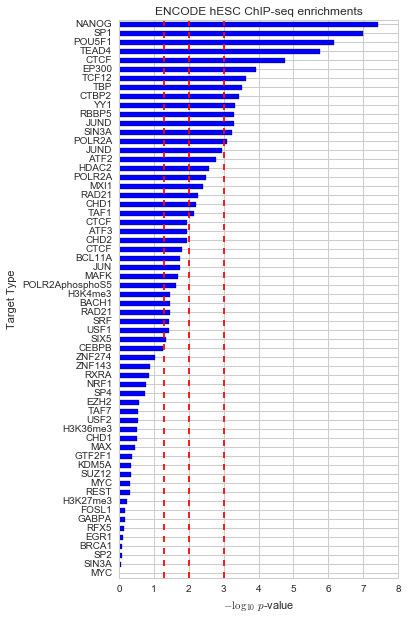

In [79]:
with sns.axes_style('whitegrid'):
    t = encode_chip_seq_res.sort_values(by='pvalue', ascending=False)
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax)
    ax.set_ylabel('Target Type')
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_title('ENCODE hESC ChIP-seq enrichments')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='red', linestyle='--')
    ax.set_yticklabels(t.target);

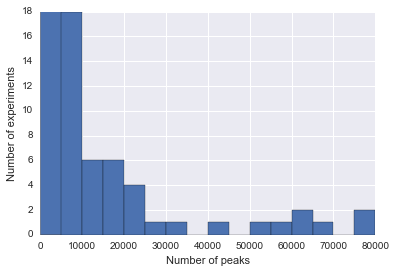

In [80]:
encode_chip_seq_res.num_peaks.hist(bins=np.arange(0, 85000, 5000))
plt.xlabel('Number of peaks')
plt.ylabel('Number of experiments');

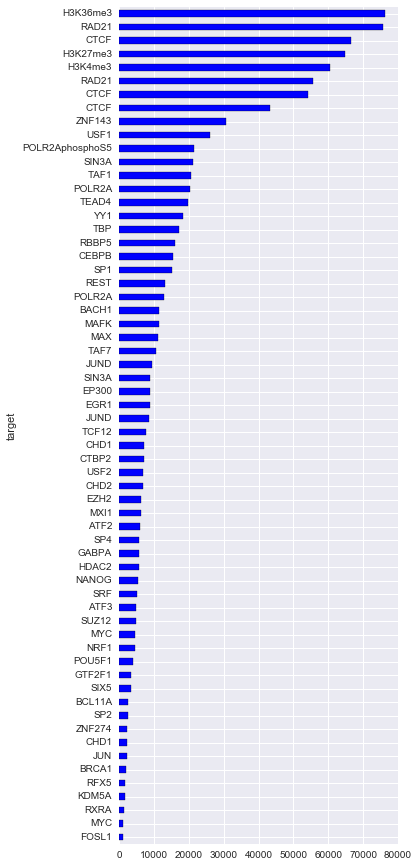

In [81]:
plt.figure(figsize=(5, 15))
se = encode_chip_seq_res.num_peaks.copy(deep=True)
se.index = encode_chip_seq_res.target
se.sort_values(inplace=True)
se.plot.barh();

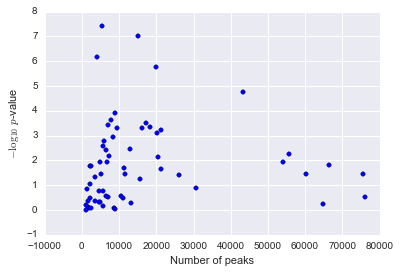

In [82]:
plt.scatter(encode_chip_seq_res.num_peaks, -np.log10(encode_chip_seq_res.pvalue))
plt.xlabel('Number of peaks')
plt.ylabel('$-\\log_{10}$ $p$-value');

In [83]:
encode_chip_seq[encode_chip_seq.target == 'POU5F1']

,cell_type,narrowPeak_accession,narrowPeak_url,target,target_type
ENCSR000BMU,H1-hESC,ENCFF002CJF,https://www.encodeproject.org/files/ENCFF002CJ...,POU5F1,"RNA binding protein, transcription factor"


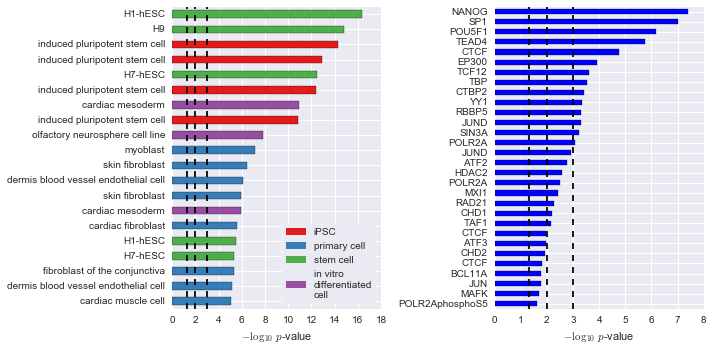

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs = axs.flatten()
ax = axs[0]
t = encode_dnase[encode_dnase.biosample_type != 'immortalized cell line']
t = encode_dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(20)
cdict = dict(zip(set(encode_dnase.ix[t.index, 'biosample_type']), sns.color_palette('Set1')))
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
c = [cdict[x] for x in encode_dnase.ix[t.index, 'biosample_type']]
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value')
#ax.set_title('ENCODE DNase enrichments')
ya, yb = ax.get_ylim()
ax.vlines(-np.log10(0.05), ya, yb, color='black', linestyle='--')
ax.vlines(-np.log10(0.01), ya, yb, color='black', linestyle='--')
ax.vlines(-np.log10(0.001), ya, yb, color='black', linestyle='--')
ax.set_yticklabels(encode_dnase.ix[t.index, 'cell_type'])
rects = []
labels = []
for k in cdict.keys():
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    else:
        labels.append(k)
    r = Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='lower right', frameon=True)
#bbox_to_anchor=[0.5, -0.05])#, prop={'size':8}), loc='upper center',
for p in lgd.get_patches():
    p.set_linewidth(0)

ax = axs[1]
t = encode_chip_seq_res.sort_values(by='pvalue', ascending=False).tail(30)
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value')
#ax.set_title('ENCODE hESC ChIP-seq enrichments')
ya, yb = ax.get_ylim()
ax.vlines(-np.log10(0.05), ya, yb, color='black', linestyle='--')
ax.vlines(-np.log10(0.01), ya, yb, color='black', linestyle='--')
ax.vlines(-np.log10(0.001), ya, yb, color='black', linestyle='--')
ax.set_yticklabels(t.target)
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'enrichments.png'),
            bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=600)